### B. Preprocessing
*********************************************************************************************************************
### Parameters Explanation :
* In order to train our model on a pre-built network, as we will see further on, we first had to resize our images and label masks to a 224 × 224 × 3 size. As the labels we extracted from OSM only consisted of the ”buildings” layer, there was no need for an entire RGB channel, so we converted the label images to a binary mask of size 224×224×1 with 1 for pixels labeled as ”buildings”, 0 otherwise. Below is one of the satellite images from our dataset, along with its corresponding mask:

* Fig. 1. Satellite image and corresponding mask with buildings identified in white.
One advantage of our dataset is that the images were labeled by humans, resulting in a quite good accuracy. However, a non-negligible proportion of satellite images were not up-to-date with the most recent masks, as new buildings had already been added by users. Some images were also blurry. Overall, this likely decreased the performance of our model – as it had partially learned on mislabeled and/or blurry training images – and led to a suboptimal performance at test time.

* Unfortunately, the training was not progressing properly at first, because of the class imbalance. Indeed, most of our images had far more non-building pixels than building pixels. Therefore, we decided to put a threshold of 15% on the minimum ratio of building pixels per image and ended up with a dataset of 3042 images. We split that dataset according to a 70%/15%/15% train/dev/test ratio, ie. 2129, 456 and 456 images respectively. This is a relatively small dataset, which is one of the reasons that led us to apply data augmentation, as we will see later. We then centered and normalized our images, and shuffled the dataset.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py

seed = 56



Using TensorFlow backend.


In [2]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_CHANNELS = 3
image_file = '../Data/Road/train_images.h5py'
mask_file = '../Data/Road/train_masks.h5py'

In [3]:
hfile = h5py.File(image_file, 'r')
n1 = hfile.get('all_images')
images = np.array(n1)
print(images.shape)
hfile.close()

(27588, 256, 256, 3)


In [4]:
hfile = h5py.File(mask_file, 'r')
n1 = hfile.get('all_masks')
masks = np.array(n1)
print(masks.shape)
print("Unique elements in the train mask:", np.unique(masks))
hfile.close()

(27588, 256, 256)
Unique elements in the train mask: [  0 255]


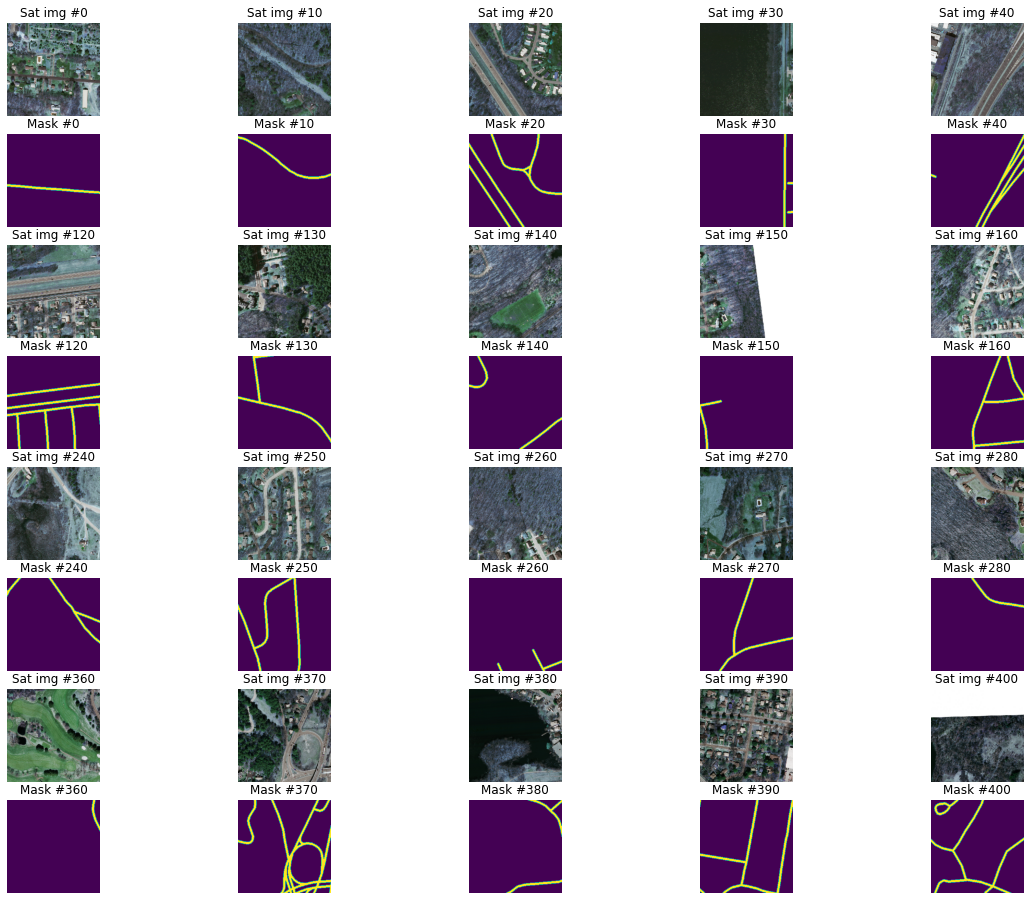

In [5]:
plt.figure(figsize=(20,16))
x, y = 5,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(images[pos])
        plt.title('Sat img #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
           
        
        plt.imshow(masks[pos])
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()
masks = np.expand_dims(masks, -1)

In [6]:
#accuracy Metric
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
    return iou

In [7]:
#loss function
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [8]:
print(masks.shape)
print(images.shape)

(27588, 256, 256, 1)
(27588, 256, 256, 3)


In [9]:
#spliting data
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=seed)
del images, masks
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(22070, 256, 256, 3)
(22070, 256, 256, 1)
TEST SET
(5518, 256, 256, 3)
(5518, 256, 256, 1)


In [10]:
#HyperParameters of model
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

In [11]:
#defining our model
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras

In [12]:
inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)

upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [14]:
keras.callbacks.TensorBoard(log_dir='..\Graph', histogram_freq=0,  
          write_graph=True, write_images=True)


In [15]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='..\Graph', histogram_freq=0, write_graph=True, write_images=True)

In [16]:
model_path = "../Models/road_mapper_2.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)

In [17]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])


# Training :
 The training was carried out on Floydhub GPUs (Tesla K80). Considering the memory available on the GPU, we did a training on mini-batches of 32 images. We went through approximately 120 epochs over a total of 6 hours. We started from a learning rate of 0.001. Each time a plateau was reached for more than 5 epochs (ie. each time the loss did not decrease for 5 epochs), we reduced the learning rate by 50%, using the Keras callback ReduceLROnPlateau. We considered the training to be complete when no progress was seen for more than 20 epochs. We can see below that there is no overfitting – partly thanks to data augmentation – as we converge towards a Dice coefficient of approximately 0.75 for both the training set and the development set.

In [18]:
history = model.fit(train_images,
                    train_masks/255,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, earlystopper, lr_reducer,tbCallBack]
                       )

Train on 19863 samples, validate on 2207 samples
Epoch 1/100
19863/19863 [==============================] - 1198s 60ms/step - loss: 0.6199 - iou_coef: 0.2218 - val_loss: 0.4388 - val_iou_coef: 0.3529

Epoch 00001: val_loss improved from inf to 0.43877, saving model to ../Models/road_mapper_2.h5
Epoch 2/100
19863/19863 [==============================] - 1164s 59ms/step - loss: 0.3936 - iou_coef: 0.3989 - val_loss: 0.3428 - val_iou_coef: 0.4501

Epoch 00002: val_loss improved from 0.43877 to 0.34282, saving model to ../Models/road_mapper_2.h5
Epoch 3/100
19863/19863 [==============================] - 1058s 53ms/step - loss: 0.3264 - iou_coef: 0.4709 - val_loss: 0.3079 - val_iou_coef: 0.4959

Epoch 00003: val_loss improved from 0.34282 to 0.30795, saving model to ../Models/road_mapper_2.h5
Epoch 4/100
19863/19863 [==============================] - 957s 48ms/step - loss: 0.3062 - iou_coef: 0.4975 - val_loss: 0.2968 - val_iou_coef: 0.5081

Epoch 00004: val_loss improved from 0.30795 to 0.29


Epoch 00034: val_loss improved from 0.24971 to 0.24768, saving model to ../Models/road_mapper_2.h5
Epoch 35/100
19863/19863 [==============================] - 958s 48ms/step - loss: 0.2335 - iou_coef: 0.5893 - val_loss: 0.2472 - val_iou_coef: 0.5734

Epoch 00035: val_loss improved from 0.24768 to 0.24719, saving model to ../Models/road_mapper_2.h5
Epoch 36/100
19863/19863 [==============================] - 956s 48ms/step - loss: 0.2322 - iou_coef: 0.5909 - val_loss: 0.2484 - val_iou_coef: 0.5694

Epoch 00036: val_loss did not improve from 0.24719
Epoch 37/100
19863/19863 [==============================] - 963s 48ms/step - loss: 0.2319 - iou_coef: 0.5923 - val_loss: 0.2475 - val_iou_coef: 0.5720

Epoch 00037: val_loss did not improve from 0.24719
Epoch 38/100
19863/19863 [==============================] - 963s 48ms/step - loss: 0.2307 - iou_coef: 0.5936 - val_loss: 0.2489 - val_iou_coef: 0.5734

Epoch 00038: val_loss did not improve from 0.24719
Epoch 39/100
19863/19863 [==============

In [20]:
model.save("../Models/Road_Detection_final.h5")

In [21]:
#testing
model = load_model("../Models/Road_Detection_final.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

In [22]:
model.evaluate(test_images, test_masks)

5518/5518 [==============================] - 94s 17ms/step


[-0.4570873403687458, 6.23154354095459]

In [23]:
predictions = model.predict(test_images, verbose=1)

5518/5518 [==============================] - 82s 15ms/step


In [24]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

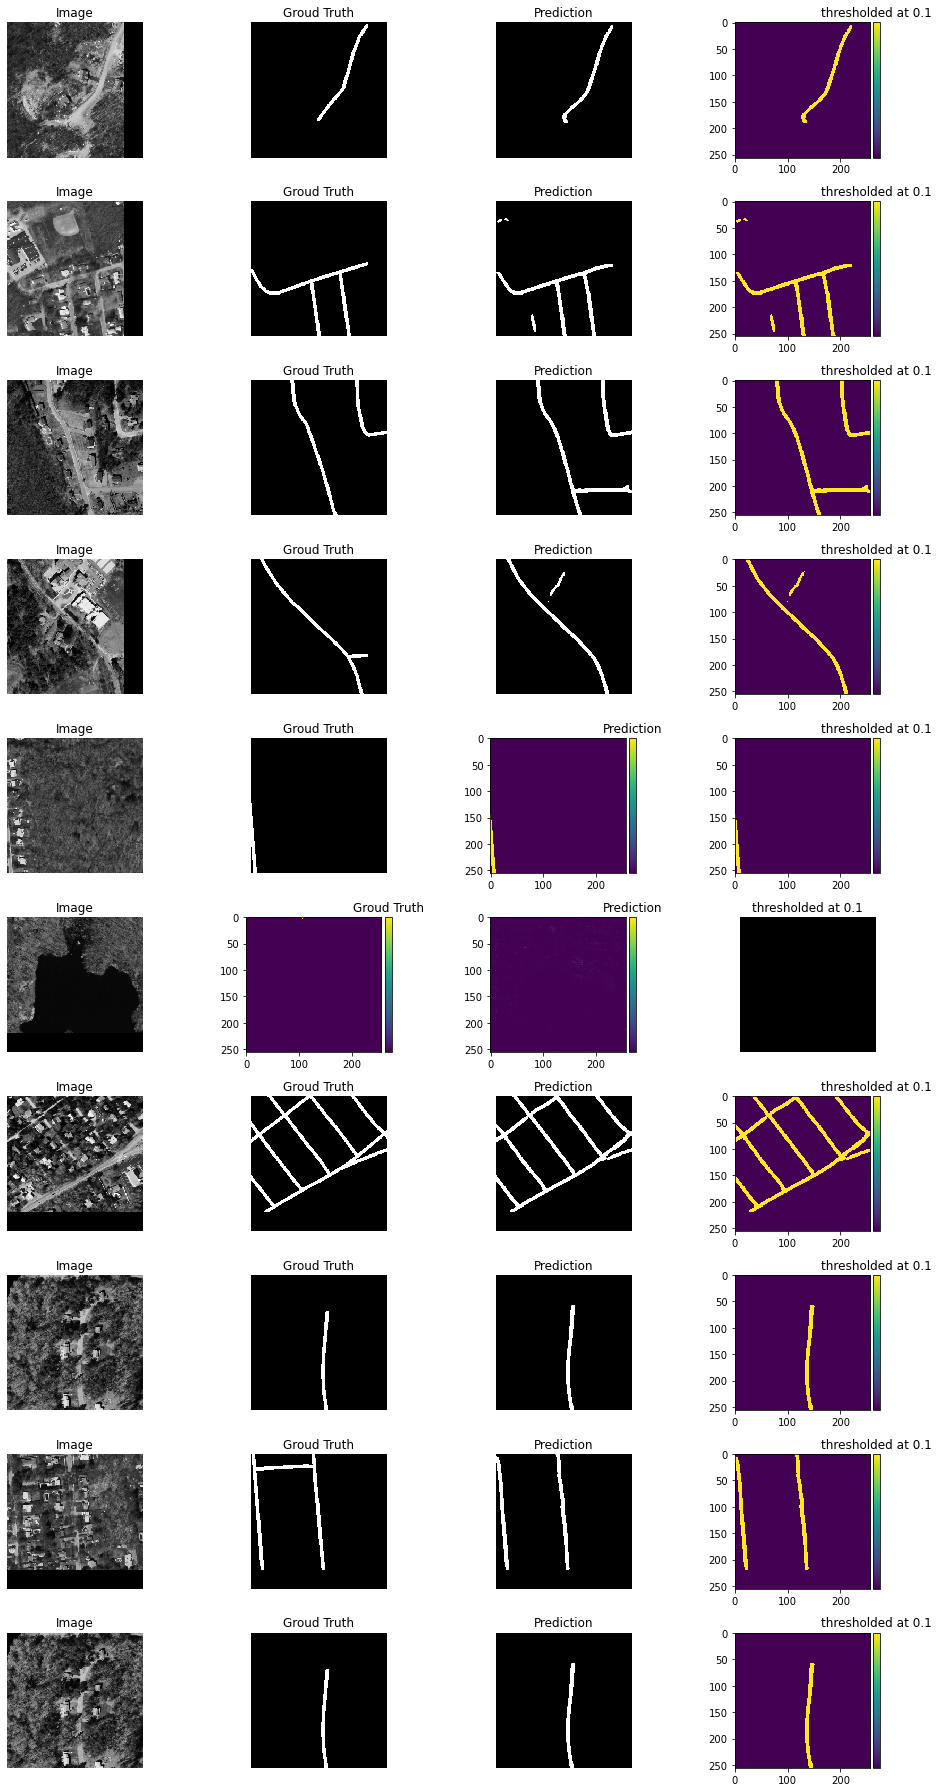

In [25]:
ix = random.randint(0, len(predictions))
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  ix = random.randint(0, len(predictions))

  f.add_subplot(num_samples, 4, i)
  imshow(test_images[ix][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  imshow(np.squeeze(test_masks[ix][:,:,0]))
  plt.title("Groud Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  imshow(np.squeeze(predictions[ix][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  imshow(np.squeeze(predicton_threshold[ix][:,:,0]))
  plt.title("thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()
